In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

from utils.gpu_memory import limited_gpu_memory

In [2]:
limited_gpu_memory()

memory growth: True


In [3]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [4]:
# データセットのシェイプの確認
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


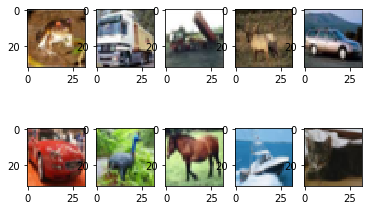

In [5]:
# データセットの画像の確認
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i])
plt.show()

In [6]:
# データセットのラベルの確認
print(train_labels[0:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


In [7]:
# データセットの前処理
train_images = train_images
train_labels = to_categorical(train_labels)
test_images = test_images
test_labels = to_categorical(test_labels)

In [8]:
# データセットの前処理後のシェイプの確認
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [9]:
def conv(filters, kernel_size, strides=1):
    return Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))

In [10]:
def first_residual_unit(filters, strides):
    def f(x):
        x = BatchNormalization()(x)
        b = Activation('relu')(x)

        x = conv(filters // 4, 1, strides)(b)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = conv(filters // 4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = conv(filters, 1)(x)

        sc = conv(filters, 1, strides)(b)

        return Add()([x, sc])

    return f

In [11]:
def residual_unit(filters):
    def f(x):
        sc = x

        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = conv(filters // 4, 1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = conv(filters // 4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = conv(filters, 1)(x)

        return Add()([x, sc])

    return f

In [12]:
def residual_block(filters, strides, unit_size):
    def f(x):
        x = first_residual_unit(filters, strides)(x)
        for i in range(unit_size - 1):
            x = residual_unit(filters)(x)
        return x

    return f

In [13]:
input = Input(shape=(32, 32, 3))

x = conv(16, 3)(input)

# 残差ブロック * 54
x = residual_block(32, 1, 18)(x)
x = residual_block(64, 2, 18)(x)
x = residual_block(128, 2, 18)(x)

x = BatchNormalization()(x)
x = Activation('relu')(x)

x = GlobalAveragePooling2D()(x)

output = Dense(10, activation='softmax', kernel_regularizer=l2(0.0001))(x)

model = Model(inputs=input, outputs=output)

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['acc'])

In [15]:
train_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True
)
test_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

for data in (train_gen, test_gen):
    data.fit(train_images)

In [16]:
def step_decay(epoch):
    x = 0.1
    if epoch >= 30:
        x = 0.01

    return x

lr_decay = LearningRateScheduler(step_decay)


In [17]:
batch_size = 128
history = model.fit(
    train_gen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=50,
    steps_per_epoch=train_images.shape[0] // batch_size,
    validation_data=test_gen.flow(test_images, test_labels, batch_size=batch_size),
    validation_steps=test_images.shape[0] // batch_size,
    callbacks=[lr_decay])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 390 steps, validate for 78 steps
Epoch 1/50
390/390 [==============================] - 109s 281ms/step - loss: 3.2597 - acc: 0.3571 - val_loss: 3.1709 - val_acc: 0.4141
Epoch 2/50
390/390 [==============================] - 64s 163ms/step - loss: 2.6968 - acc: 0.5108 - val_loss: 2.6267 - val_acc: 0.5053
Epoch 3/50
390/390 [==============================] - 63s 162ms/step - loss: 2.3188 - acc: 0.5941 - val_loss: 2.4259 - val_acc: 0.5517
Epoch 4/50
390/390 [==============================] - 64s 165ms/step - loss: 2.0287 - acc: 0.6533 - val_loss: 1.9791 - val_acc: 0.6488
Epoch 5/50
390/390 [==============================] - 64s 165ms/step - loss: 1.8129 - acc: 0.6891 - val_loss: 2.1481 - val_acc: 0.5967
Epoch 6/50
390/390 [==============================] - 64s 164ms/step - loss: 1.6234 - acc: 0.7203 - val_loss: 1.6795 - val_acc: 0.6874
Epoch 7/50
390/390 [==============================] - 64s 163ms/step - loss: 1.4769 - acc: 0.743

In [18]:
# モデルの保存
model.save('resnet.h5')

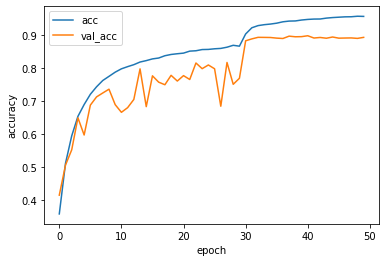

In [19]:
# グラフの表示
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [20]:
# 評価
batch_size = 128
test_loss, test_acc = model.evaluate_generator(
    test_gen.flow(test_images, test_labels, batch_size=batch_size),
    steps=10)
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc ))

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
loss: 0.567
acc: 0.897


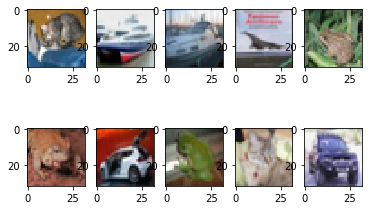

Instructions for updating:
Please use Model.predict, which supports generators.
['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']


In [21]:
# 推論する画像の表示
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])
plt.show()

# 推論したラベルの表示
test_predictions = model.predict_generator(
    test_gen.flow(test_images[0:10], shuffle = False, batch_size=1),
    steps=10)
test_predictions = np.argmax(test_predictions, axis=1)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
        'dog', 'frog', 'horse', 'ship', 'truck']
print([labels[n] for n in test_predictions])